In [241]:
import os
import re

os.chdir("/home/s2113174/Projects-1")
#os.chdir("d://Projects//Projects-1/")

import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from collections import OrderedDict

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

from pyDOE import lhs
from scipy.stats import uniform,norm
from scipy.interpolate import griddata

from GaLa_v4 import llaplace

#np.random.seed(1234)

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Taylor Green Vortex

$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0 $$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial x} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$

$$\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x}+ v\frac{\partial u}{\partial y} = - \frac{1}{\rho}\frac{\partial p}{\partial y} + \nu (\frac{\partial^{2} u}{\partial x^{2}} + \frac{\partial^{2} v}{\partial y^{2}})$$



where $0 \leq x,y \leq \pi$ and boundary conditions
$$u(x,0) = sin( x)e^{-2 \nu t}, u(x,\pi) = -sin( x)e^{-2 \nu t}$$
$$u(0,y) = u(\pi,y) =0 $$


$$v(0,y) = -sin( y)e^{-2 \nu t}, v(\pi,y) = -sin(y)e^{-2 \nu t}$$
$$v(x,0) = u(x,\pi) =0 $$

This equation has the following analytical solution.

$$u(x,y,t)= sin(x)cos(y)e^{-2 \nu t}$$
$$v(x,y,t)= -cos(x)sin(y)e^{-2 \nu t}$$

In [242]:
def exact_sol(x,y,t,nu):
    u = np.sin(x)*np.cos(y)*np.exp(-2*nu*t)
    v = -np.cos(x)*np.sin(y)*np.exp(-2*nu*t)
    return u, v

def p_exact_sol(x,y,t,nu,ro = 1):
    return (ro/4)*(np.cos(2*x) + np.sin(2*y))*np.exp(-4*nu*t)

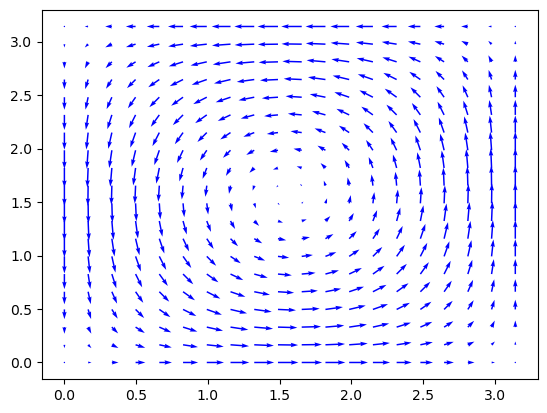

Text(0.5, 0, 'x')

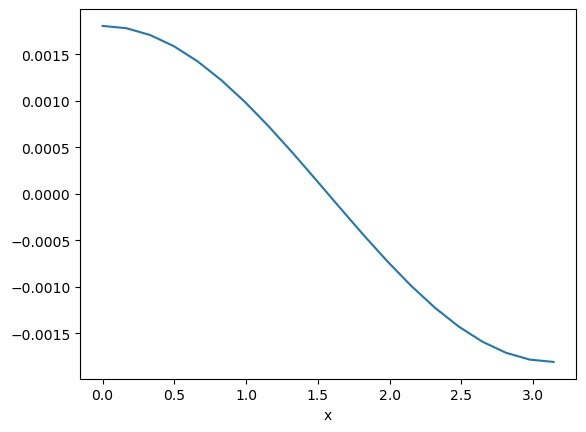

In [243]:
x = np.linspace(0,1,20)*np.pi
y = np.linspace(0,1,20)*np.pi
t = np.linspace(0,100,100)
nu = 1/16

xx, yy, tt = np.meshgrid(x, y,t)

fig,ax = plt.subplots()

u,v = exact_sol(xx[:,:,0],yy[:,:,0],tt[:,:,50],nu)
img = ax.quiver(x, y, u, v, color='blue') 
plt.show()
plt.plot(x,u[:,9])
plt.xlabel("x")

# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")

#     u,v = exact_sol(xx,yy,t[i],nu)

#     img = ax.quiver(x, y, u, v, color='blue') 

#     return img

# ani = FuncAnimation(fig, animate, interval=1, blit=False, repeat=True, frames=100)    
# ani.save("TGV_exact.gif", dpi=300, writer=PillowWriter(fps=25))

## Feed Forward Neural Network

In [244]:
# Deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [245]:
# Deep neural network
class Dropout_DNN(torch.nn.Module):
    def __init__(self, layers):
        super(Dropout_DNN, self).__init__()

        # Number of layers
        self.depth = len(layers) - 1
        
        # Activation Function
        self.activation = torch.nn.Tanh
        
        # The following loop organized the layers of the NN         
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1])))
            layer_list.append(('activation_%d' % i, self.activation()))
            layer_list.append(('dropout_%d' % i, torch.nn.Dropout(p = 0.4)))

        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # Deploy layers
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

## Parametric Neural PDE

In [246]:
def de(self,data_domain, ro = 1):
    """ The pytorch autograd version of calculating residual """
    f = self(data_domain)
    
    du = torch.autograd.grad(
        f[:,0], data_domain, 
        grad_outputs=torch.ones_like(f[:,0]),
        retain_graph=True,
        create_graph=True
    )[0]

    dv = torch.autograd.grad(
        f[:,1], data_domain, 
        grad_outputs=torch.ones_like(f[:,1]),
        retain_graph=True,
        create_graph=True
    )[0]

    dp = torch.autograd.grad(
        f[:,2], data_domain, 
        grad_outputs=torch.ones_like(f[:,2]),
        retain_graph=True,
        create_graph=True
    )[0]
    
    ddu_x = torch.autograd.grad(
        du[:,0],data_domain, 
        grad_outputs=torch.ones_like(du[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddu_y = torch.autograd.grad(
        du[:,1],data_domain, 
        grad_outputs=torch.ones_like(du[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_x = torch.autograd.grad(
        dv[:,0],data_domain, 
        grad_outputs=torch.ones_like(dv[:,0]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    ddv_y = torch.autograd.grad(
        dv[:,1],data_domain, 
        grad_outputs=torch.ones_like(dv[:,1]),
        retain_graph=True,
        create_graph=True
        )[0]
    
    r = du[:,0].reshape(-1,1) + dv[:,1].reshape(-1,1)
    g = du[:,2].reshape(-1,1) + f[:,0].reshape(-1,1) *du[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*du[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,0].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddu_x[:,0].reshape(-1,1) + ddu_y[:,1].reshape(-1,1))
    
    h = dv[:,2].reshape(-1,1) + f[:,0].reshape(-1,1)*dv[:,0].reshape(-1,1) + f[:,1].reshape(-1,1)*dv[:,1].reshape(-1,1) +\
                (1/ro)*dp[:,1].reshape(-1,1) - data_domain[:,-1].reshape(-1,1)*(ddv_x[:,0].reshape(-1,1) + ddv_y[:,1].reshape(-1,1))
    return torch.cat([r,g,h],axis = 1)

def down_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) - torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def up_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,0].reshape(-1,1) + torch.sin(data_inic[:,0].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*torch.cos(2*data_inic[:,0].reshape(-1,1))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([bc1,f[:,1].reshape(-1,1),bc3],axis = 1)

def left_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) + torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

def right_bc(self,data_inic, ro = 1):
    f = self(data_inic)
    bc1 = f[:,1].reshape(-1,1) - torch.sin(data_inic[:,1].reshape(-1,1))*torch.exp(-2*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    bc3 = f[:,2].reshape(-1,1) -(ro/4)*(1+torch.sin(2*data_inic[:,1].reshape(-1,1)))*torch.exp(-4*data_inic[:,3].reshape(-1,1)*data_inic[:,2].reshape(-1,1))
    return torch.cat([f[:,0].reshape(-1,1),bc1,bc3],axis = 1)

In [247]:
DNN.de = de
DNN.down_bc = down_bc
DNN.up_bc = up_bc
DNN.left_bc = left_bc
DNN.right_bc = right_bc


Dropout_DNN.de = de
Dropout_DNN.down_bc = down_bc
Dropout_DNN.up_bc = up_bc
Dropout_DNN.left_bc = left_bc
Dropout_DNN.right_bc = right_bc

In [248]:
def samples_space(size = 10,maxl = np.pi):
    xyt = lhs(3, size)
    xyt[:,:2] = xyt[:,:2]*maxl
    xyt[:,-1] = xyt[:,-1]*10
    return xyt

def samples_param(min,max,size = 100):
    return np.random.uniform(min,max,size = size)

In [249]:
def data_pde(size,minp,maxp):

    xyt, param = samples_space(size),samples_param(minp,maxp,(size,1)).reshape(-1,1)
    pde_domain = torch.tensor(np.hstack((xyt,param.reshape(-1,1)))).float()
    
    x,y,t = torch.tensor(xyt[:,0]).reshape(-1,1),torch.tensor(xyt[:,1]).reshape(-1,1),torch.tensor(xyt[:,2]).reshape(-1,1)
    param = torch.tensor(param).reshape(-1,1)
    
    down_bc = torch.cat([x,torch.zeros_like(x).float(),t, param],axis = 1).float()

    up_bc = torch.cat([x,torch.ones_like(x).float()*(torch.pi),t, param],axis = 1).float()

    left_bc = torch.cat([torch.zeros_like(y).float(),y,t, param],axis = 1).float()

    right_bc = torch.cat([torch.ones_like(y).float()*(torch.pi),y,t, param],axis = 1).float()

    return pde_domain,down_bc,up_bc,left_bc,right_bc

In [250]:
def train_adam(pinn,loss,optimizer,epochs, sample_size = 100,minval_param = 0.2,maxval_param = 2,repetitions=1):
      print("Starting Adam Training")
      train_loss=[]
      
      for i in range(epochs):
        pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
        pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

        pde_domain = Variable(pde_domain,requires_grad=True)
        down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
        left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
        
        for _ in range(repetitions):
                optimizer.zero_grad()

                pde_pred  = pinn.de(pde_domain)
                down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
                left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

                zeros = torch.zeros_like(pde_pred)

                loss_pde = loss(pde_pred,zeros)
                loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
                loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

                Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
                
                train_loss.append(Loss.item())

                if i % 10 == 0:
                        print('Iter %d, Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % (i, 
                                                 Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item()))      
                Loss.backward() 

                optimizer.step() 
                
      return train_loss

In [251]:
def train_LBFGS(pinn,loss,optimizer, sample_size = 100,minval_param = 0.2,maxval_param = 2):
    print("Starting Training: LBFGS optimizer")
    train_loss=[]

    pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(sample_size,minval_param,maxval_param)
    pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain.to(device),down_bc.to(device),up_bc.to(device),left_bc.to(device),right_bc.to(device)

    pde_domain = Variable(pde_domain,requires_grad=True)
    down_bc,up_bc = Variable(down_bc,requires_grad=True),Variable(up_bc,requires_grad=True)
    left_bc,right_bc = Variable(left_bc,requires_grad=True),Variable(right_bc,requires_grad=True)
    

    def loss_func_train():
        optimizer.zero_grad()
        
        pde_pred  = pinn.de(pde_domain)
        down_bc_pred,up_bc_pred = pinn.down_bc(down_bc),pinn.up_bc(up_bc)
        left_bc_pred,right_bc_pred = pinn.left_bc(left_bc),pinn.right_bc(right_bc)

        zeros = torch.zeros_like(pde_pred)

        loss_pde = loss(pde_pred,zeros)
        loss_dbc,loss_ubc = loss(down_bc_pred,zeros),loss(up_bc_pred,zeros)
        loss_lbc,loss_rbc = loss(left_bc_pred,zeros),loss(right_bc_pred,zeros)

        Loss =  3*(loss_pde + loss_dbc + loss_ubc + loss_lbc + loss_rbc)
        
        train_loss.append(Loss.item())

        print('Loss: %.5e, Loss_pde: %.5e,Loss_dbc: %.5e,Loss_ubc: %.5e,Loss_lbc: %.5e,Loss_rbc: %.5e' % ( 
                                        Loss.item(),loss_pde.item(),loss_dbc.item(), loss_ubc.item(),loss_lbc.item(), loss_rbc.item())) 
        Loss.backward() 

        return Loss

    optimizer.step(loss_func_train) 
    return train_loss

In [252]:
# Number of observations
epochs = 5000
nobs = 1000
lr = 0.01

min_param , max_param = 0.0001, 0.05

layers = [4] + 4*[80] + [3]

model = DNN(layers).to(device)
dropout_model = Dropout_DNN(layers).to(device)

In [253]:
# loss = torch.nn.MSELoss(reduction ='mean')

# optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# loss_history = train_adam(model,loss,optimizer,epochs, nobs,min_param,max_param)

# optimizer = torch.optim.LBFGS(model.parameters(), 
#     lr=lr, max_iter=50000, max_eval=None, 
#     tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
#     line_search_fn="strong_wolfe" 
#     )

# loss_history_b = train_LBFGS(model,loss,optimizer, nobs*2,min_param,max_param)

In [254]:
loss = torch.nn.MSELoss(reduction ='mean')

optimizer = torch.optim.Adam(dropout_model.parameters(), lr = lr)

loss_history = train_adam(dropout_model,loss,optimizer,epochs, nobs,min_param,max_param)

optimizer = torch.optim.LBFGS(dropout_model.parameters(), 
    lr=lr, max_iter=50000, max_eval=None, 
    tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps,
    line_search_fn="strong_wolfe" 
    )

loss_history_b = train_LBFGS(dropout_model,loss,optimizer, nobs*2,min_param,max_param)

Starting Adam Training
Iter 0, Loss: 1.86951e+00, Loss_pde: 2.04824e-03,Loss_dbc: 1.20097e-01,Loss_ubc: 1.87019e-01,Loss_lbc: 1.62938e-01,Loss_rbc: 1.51067e-01
Iter 10, Loss: 9.46117e-01, Loss_pde: 7.96670e-03,Loss_dbc: 1.04014e-01,Loss_ubc: 7.08840e-02,Loss_lbc: 6.78093e-02,Loss_rbc: 6.46982e-02
Iter 20, Loss: 6.99947e-01, Loss_pde: 6.99541e-03,Loss_dbc: 6.20378e-02,Loss_ubc: 5.84307e-02,Loss_lbc: 5.33928e-02,Loss_rbc: 5.24589e-02
Iter 30, Loss: 5.91072e-01, Loss_pde: 8.68493e-03,Loss_dbc: 5.27683e-02,Loss_ubc: 5.04148e-02,Loss_lbc: 4.35987e-02,Loss_rbc: 4.15572e-02
Iter 40, Loss: 4.87876e-01, Loss_pde: 1.22553e-02,Loss_dbc: 3.52224e-02,Loss_ubc: 3.34616e-02,Loss_lbc: 3.97906e-02,Loss_rbc: 4.18953e-02
Iter 50, Loss: 4.54711e-01, Loss_pde: 1.31005e-02,Loss_dbc: 3.42930e-02,Loss_ubc: 3.54836e-02,Loss_lbc: 3.31393e-02,Loss_rbc: 3.55540e-02
Iter 60, Loss: 4.37012e-01, Loss_pde: 1.49210e-02,Loss_dbc: 3.27322e-02,Loss_ubc: 3.24321e-02,Loss_lbc: 3.26505e-02,Loss_rbc: 3.29347e-02
Iter 70, Los

In [255]:
path = "../Projects-1/Physics _Informed_NN/GaLA/Gala_models/Taylor_Green.pt"
#torch.save(model.state_dict(),path)
model.load_state_dict(torch.load(path,  map_location=device))
model.eval()

DNN(
  (layers): Sequential(
    (layer_0): Linear(in_features=4, out_features=80, bias=True)
    (activation_0): Tanh()
    (layer_1): Linear(in_features=80, out_features=80, bias=True)
    (activation_1): Tanh()
    (layer_2): Linear(in_features=80, out_features=80, bias=True)
    (activation_2): Tanh()
    (layer_3): Linear(in_features=80, out_features=80, bias=True)
    (activation_3): Tanh()
    (layer_4): Linear(in_features=80, out_features=3, bias=True)
  )
)

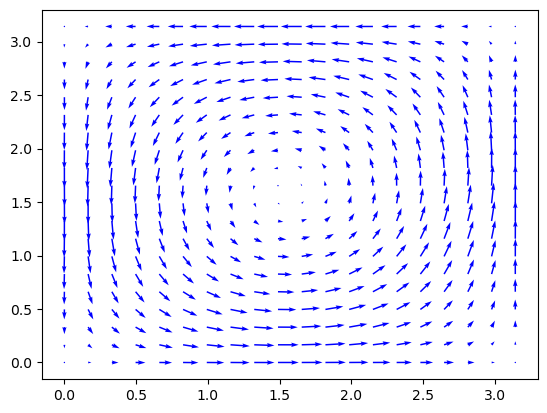

Text(0.5, 0, 'x')

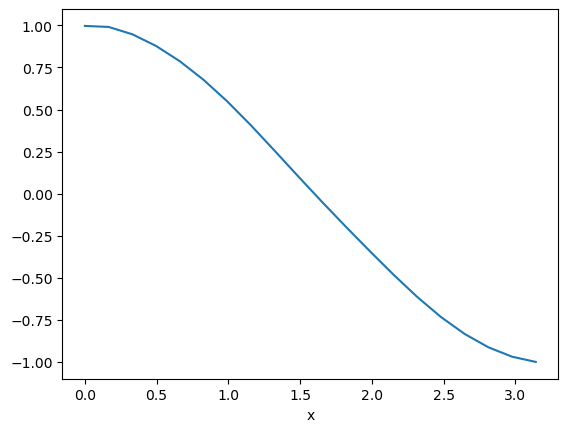

In [256]:
x = np.linspace(0,1,20)*np.pi
y = np.linspace(0,1,20)*np.pi
t = np.linspace(0,2,10)
nu = 1/100

xx, yy = np.meshgrid(x, y)

xx, yy = torch.tensor(xx).reshape(-1,1).float().to(device),torch.tensor(yy).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,torch.ones_like(xx).to(device)*(t[0]),torch.ones_like(xx).to(device)*(nu)],axis = 1)

f = model(X_star)

xx, yy = np.meshgrid(x, y)

u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,0].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')
v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f[:,1].cpu().detach().numpy().flatten(), (xx,yy), method='cubic')

plt.quiver(x, y, u, v, color='blue') 
plt.show()
plt.plot(x,u[:,9])
plt.xlabel("x")

In [257]:
x = np.linspace(0,1,50)*np.pi
y = np.linspace(0,1,50)*np.pi
t = np.linspace(0,10,100)
nu = 1/100

xx, yy,tt = np.meshgrid(x, y, t)

xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

dropout_model.train()

predictions = []

for _ in range(10000):
    pred = dropout_model(X_star)  # Perform a forward pass with dropout
    predictions.append(pred.detach().numpy())  # Store the result

predictions = np.array(predictions)
mean_pred = np.mean(predictions, axis=0)  # Mean prediction
std_pred = np.std(predictions, axis=0)  # Standard deviation (uncertainty)

# return mean_pred, std_pred

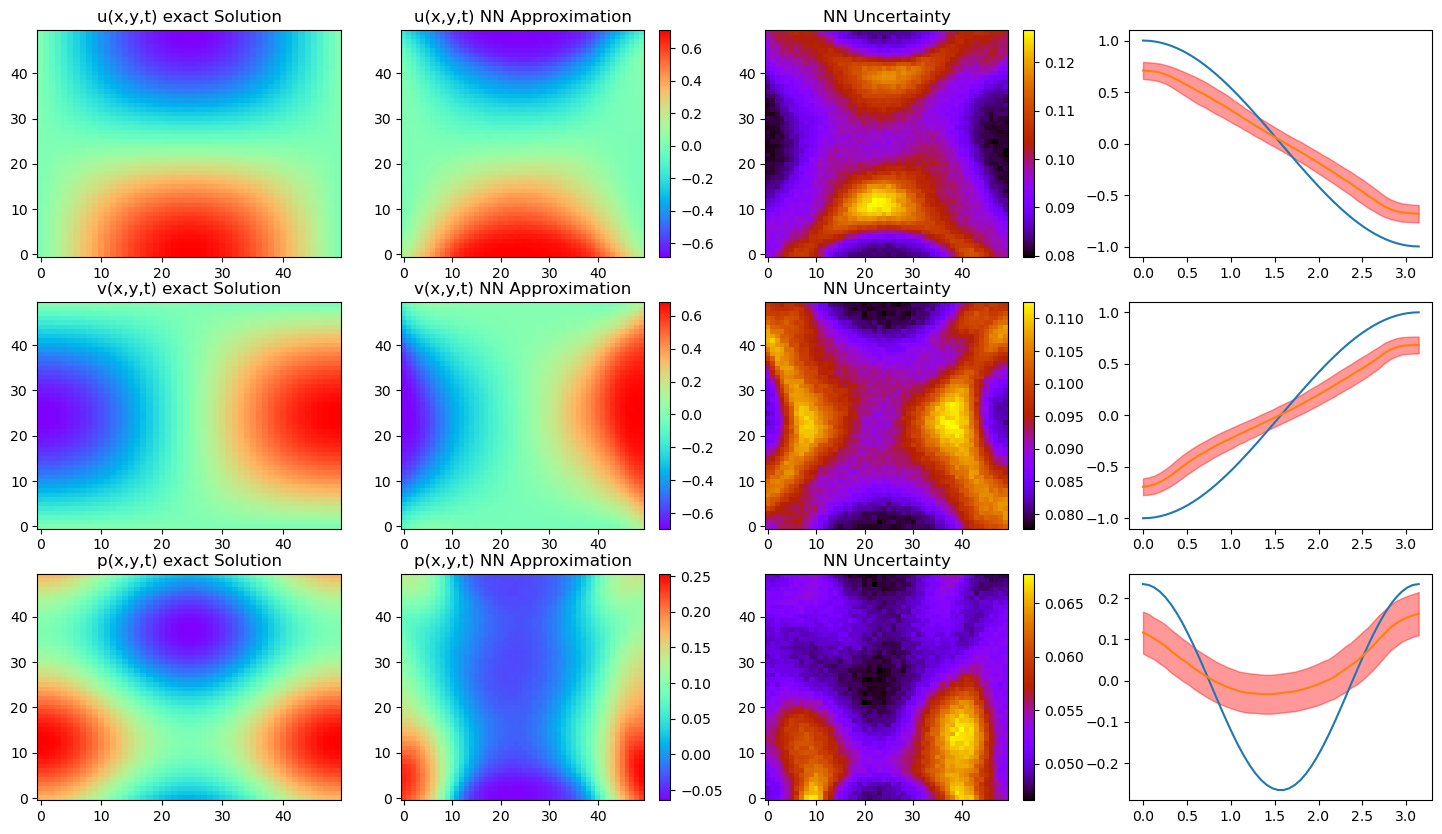

In [258]:
u,v = exact_sol(xx,yy,tt,nu)
p = p_exact_sol(xx,yy,tt,nu)

xx, yy = np.meshgrid(x, y)

u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred[:,0], (xx,yy), method='cubic')
u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred[:,0], (xx,yy), method='cubic')
v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred[:,1], (xx,yy), method='cubic')
v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred[:,1], (xx,yy), method='cubic')
p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), mean_pred[:,2], (xx,yy), method='cubic')
p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), std_pred[:,2], (xx,yy), method='cubic')


fig,ax = plt.subplots(3,4,figsize=(18,10))
       
ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
ax[0,0].set_title("u(x,y,t) exact Solution")
uu = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(uu) 
ax[0,1].set_title("u(x,y,t) NN Approximation")
h = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
ax[0,2].set_title("NN Uncertainty")
plt.colorbar(h) 
ax[0,3].plot(x,u[:,25])
ax[0,3].plot(x,u_pred[:,25])
ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
ax[1,0].set_title("v(x,y,t) exact Solution")
uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(uu) 
ax[1,1].set_title("v(x,y,t) NN Approximation")
h = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
ax[1,2].set_title("NN Uncertainty")
plt.colorbar(h) 
ax[1,3].plot(x,v[25,:])
ax[1,3].plot(x,v_pred[25,:])
ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
ax[2,0].set_title("p(x,y,t) exact Solution")
uu = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(uu) 
ax[2,1].set_title("p(x,y,t) NN Approximation")
h = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
ax[2,2].set_title("NN Uncertainty")
plt.colorbar(h) 
ax[2,3].plot(x,p[25,:])
ax[2,3].plot(x,p_pred[25,:])
ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


0.09999999403953552
0.09995099902153015
0.09985175728797913
0.0996825098991394
0.09941533207893372
0.09901052713394165
0.0984109491109848
0.09753447771072388
0.09626360982656479
0.09443369507789612
0.09182673692703247
0.08818438649177551
0.0832703709602356
0.07699942588806152
0.06958740949630737
0.06157921254634857
0.05366508662700653
0.04960976541042328
0.055079877376556396
0.05929867923259735
0.06225104629993439
0.06397942453622818
0.06455223262310028
0.06405370682477951
0.05393506959080696
0.05287902429699898
0.05090658366680145
0.04793526977300644
0.04407346993684769
0.03946708142757416
0.03427542746067047
0.02866295725107193
0.02279306948184967
0.022151723504066467
0.02242124080657959
0.022241488099098206
0.021713972091674805
0.020929396152496338
0.019967377185821533
0.018896907567977905
0.018240541219711304
0.02146133780479431
0.02414397895336151
0.026285499334335327
0.02789004147052765
0.028968557715415955
0.02953779697418213
0.02962091565132141
0.029247328639030457
0.0284537374

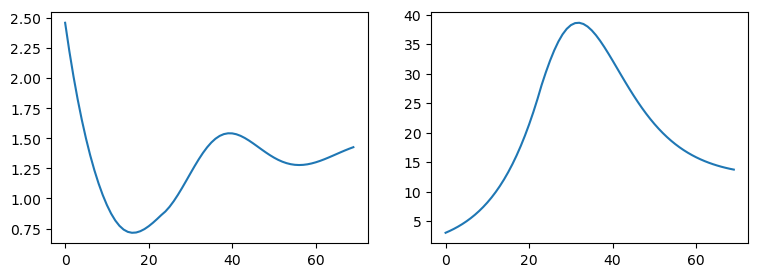

In [86]:
pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(100,min_param,max_param)

pde = {"PDE":["de","down_bc","up_bc","left_bc","right_bc"], 
       "data_set":{"de" : Variable(pde_domain.to(device),requires_grad=True),
                   "down_bc":down_bc.to(device),
                   "up_bc":up_bc.to(device),
                   "left_bc":left_bc.to(device),
                   "right_bc" :right_bc.to(device)}}

llp = llaplace(model,sigma_noise=1, prior_precision=1)
llp.fit(pde=pde, hessian_structure = "full")

log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

#llp.sigma_noise = torch.tensor([0.1*np.sqrt(1/12*(1 + 4) )]).float()

error = 1
logprior,logsigma = [],[]

while  error > 1e-2:
    log_prior_x, log_sigma_x = log_prior.detach().numpy()[0],log_sigma.detach().numpy()[0]

    hyper_optimizer.zero_grad()
    neg_marglik = - llp.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward(retain_graph=True)
    hyper_optimizer.step()


    logprior.append(log_prior.detach().numpy()[0])
    logsigma.append(log_sigma.detach().numpy()[0])

    error = 0.5*(abs(log_prior.detach().numpy()[0] - log_prior_x) + abs(log_sigma.detach().numpy()[0]-log_sigma_x))
    print(error)

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(np.exp(logsigma))
axs[1].plot(np.exp(logprior))

In [87]:
# data_domain = Variable(pde_domain.to(device),requires_grad=True)


In [88]:
# from torch.func import functional_call,hessian,vmap

# f =  model.de(data_domain)
# params = dict(model.named_parameters())
# param = {"layers.layer_4.weight":params["layers.layer_4.weight"],"layers.layer_4.bias":params["layers.layer_4.bias"]}

# def fcall(params, inputs):
#   outputs = functional_call(model.de, params, inputs)
#   return outputs

# def compute_loss(params, inputs):
#   outputs = vmap(fcall, in_dims=(None,0))(params, inputs) #vectorize over batch
#   return (outputs)**2
  
# def compute_hessian_loss(params, inputs):
#   return hessian(model.de, argnums=(0))(params, inputs)

# #loss = compute_loss(param, data_domain)
# #print(loss)

# hess = compute_hessian_loss(param, data_domain)

In [89]:
# from torch.func import functional_call,hessian,vmap

# f =  model.de(data_domain)
# params = dict(model.named_parameters())
# param = {"layers.layer_4.weight":params["layers.layer_4.weight"],"layers.layer_4.bias":params["layers.layer_4.bias"]}

# def fcall(params, inputs):
#   outputs = functional_call(model, params, inputs)
#   return outputs

# def loss_fn(outputs, targets):
#   return torch.mean((outputs - targets)**2, dim=0)

# def compute_loss(params, inputs):
#   outputs = vmap(fcall, in_dims=(None,0))(params, inputs) #vectorize over batch
#   return (outputs)**2
  
# def compute_hessian_loss(params, inputs):
#   return hessian(compute_loss, argnums=(0))(params, inputs)

# loss = compute_loss(param, data_domain)
# print(loss)

# hess = compute_hessian_loss(param, data_domain)
# key=list(params.keys())[0] #take weight in first layer as example key
#print(hess[key][key].shape) #Hessian of loss w.r.t first weight (shape [16, 1, 16, 1])


In [90]:
# hess['layers.layer_4.bias']['layers.layer_4.bias'].shape

In [91]:
# hess['layers.layer_4.bias']['layers.layer_4.bias'][0,:,:,:]

In [92]:
# hess['layers.layer_4.bias']['layers.layer_4.weight'][0,0,0,:,:]

In [93]:
# hess['layers.layer_4.weight']['layers.layer_4.weight'][0,0,0,0,0,:]

In [94]:
# f =  model.de(data_domain)

# loss_f = loss(f,torch.zeros_like(f))

# torch.autograd.functional.hessian(loss_f, tuple(model.layers.layer_4.parameters()))

In [95]:
# activations = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activations[name] = output.detach()
#     return hook
# f =  model.de(data_domain)
# # h1 = model.layers[-2].register_forward_hook(get_activation('layers.activation_4'))
# loss = torch.nn.MSELoss(reduction ='sum')

# llp(data_domain)
# phi_ = llp.model._features[llp.model._last_layer_name]

# phi_ = torch.cat((phi_,torch.ones(f.shape[0],1)),1) 

# loss_f = loss(f,torch.zeros_like(f))

# first_grad = torch.autograd.grad(loss_f, model.layers.layer_4.parameters(), create_graph=True, retain_graph=True)
# first_grad = torch.cat([first_grad[0], first_grad[1].reshape(f.shape[-1],1)],axis = 1).reshape(1,-1)

In [96]:
#phi_*f[0][1]*2

In [97]:
#torch.cat([first_grad[0], first_grad[1].reshape(f.shape[-1],1)],axis = 1)

In [98]:
# torch.sum(torch.einsum('bc,bd->bcd', phi_, phi_),axis = 0)*2

In [99]:
# hessian = torch.zeros((3*81,3*81))

# for i in range(3*81):

#     second_grad= torch.autograd.grad(first_grad[:,i], model.layers.layer_4.parameters(), torch.ones_like(first_grad[:,i]), create_graph=True)
#     second_grad = torch.cat([second_grad[0], second_grad[1].reshape(f.shape[-1],1)],axis = 1)
#     hessian[:,i] = second_grad.reshape(1,-1)

In [100]:
# hessian



In [101]:
# llp.H

In [102]:
# llp.H_pde

In [103]:
# from torch.func import functional_call,vjp


# def make_functional_fwd(_model):
#     def fn(data, parameters):
#         return functional_call(_model, parameters, (data,))
#     return fn

# model_func = make_functional_fwd(model) # functional forward
# params = dict(model.named_parameters()) # model parameters
# param = (params['layers.layer_4.weight'],params['layers.layer_4.bias'])

# grad_params = torch.func.hessian(model_func,argnums=1)(data_domain, param)


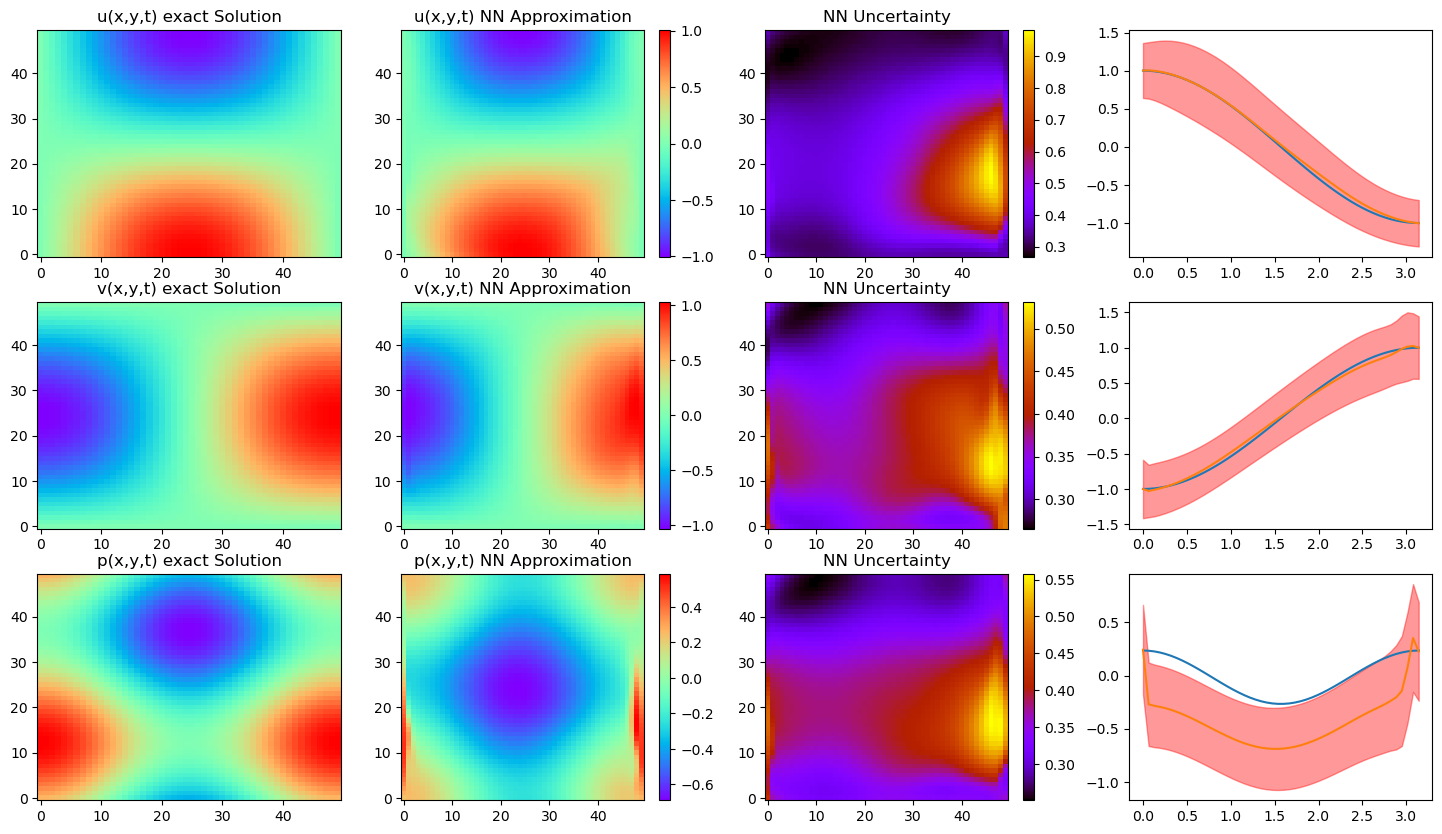

In [104]:
x = np.linspace(0,1,50)*np.pi
y = np.linspace(0,1,50)*np.pi
t = np.linspace(0,10,100)
nu = 1/100

xx, yy,tt = np.meshgrid(x, y, t)

xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,0]).reshape(-1,1).float().to(device)

X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

f_mu, f_sigma = llp(X_star)

f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()

u,v = exact_sol(xx,yy,tt,nu)
p = p_exact_sol(xx,yy,tt,nu)

xx, yy = np.meshgrid(x, y)

u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')
p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,2], (xx,yy), method='cubic')
p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,2], (xx,yy), method='cubic')


fig,ax = plt.subplots(3,4,figsize=(18,10))
       
ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
ax[0,0].set_title("u(x,y,t) exact Solution")
uu = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(uu) 
ax[0,1].set_title("u(x,y,t) NN Approximation")
h = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
ax[0,2].set_title("NN Uncertainty")
plt.colorbar(h) 
ax[0,3].plot(x,u[:,25])
ax[0,3].plot(x,u_pred[:,25])
ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
ax[1,0].set_title("v(x,y,t) exact Solution")
uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(uu) 
ax[1,1].set_title("v(x,y,t) NN Approximation")
h = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
ax[1,2].set_title("NN Uncertainty")
plt.colorbar(h) 
ax[1,3].plot(x,v[25,:])
ax[1,3].plot(x,v_pred[25,:])
ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
ax[2,0].set_title("p(x,y,t) exact Solution")
uu = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
plt.colorbar(uu) 
ax[2,1].set_title("p(x,y,t) NN Approximation")
h = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
ax[2,2].set_title("NN Uncertainty")
plt.colorbar(h) 
ax[2,3].plot(x,p[25,:])
ax[2,3].plot(x,p_pred[25,:])
ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")


In [ ]:
# from matplotlib.animation import FuncAnimation, PillowWriter
# fig,ax = plt.subplots()

# def animate(i):
#     ax.clear()
#     ax.set_title(f"Observations at time = {i+1}")
#     ax.set_xlabel("x")
#     ax.set_ylabel(fr"u(x,t={i+1})")
#     ax.set_ylim((-1.1,1.1))
#     ax.set_xlim((-1,1))
#     img = ax.plot(x,Exact[i,:],color = "blue", linewidth = 3)

#     return img

# ani = FuncAnimation(fig, animate, interval=5, blit=True, repeat=True, frames=100)    
# ani.save("TLI.gif", dpi=300, writer=PillowWriter(fps=25))

In [ ]:
# from matplotlib.animation import FuncAnimation, PillowWriter

# fig,ax = plt.subplots(3,4,figsize=(18,10))

# def animate(i):
#     x = np.linspace(0,1,50)*np.pi
#     y = np.linspace(0,1,50)*np.pi
#     t = np.linspace(0,10,100)
#     nu = 1

#     xx, yy,tt = np.meshgrid(x, y, t)

#     xx, yy,tt = torch.tensor(xx[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(yy[:,:,0]).reshape(-1,1).float().to(device),torch.tensor(tt[:,:,i]).reshape(-1,1).float().to(device)

#     X_star = torch.cat([xx,yy,tt,torch.ones_like(xx).to(device)*(nu)],axis = 1)

#     f_mu, f_sigma = llp(X_star)

#     f_mu, f_sigma= f_mu.cpu().numpy(), f_sigma.squeeze().sqrt().cpu().numpy()

#     u,v = exact_sol(xx,yy,tt,nu)
#     p = p_exact_sol(xx,yy,tt,nu)

#     xx, yy = np.meshgrid(x, y)

#     u = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), u, (xx,yy), method='cubic')
#     v = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), v, (xx,yy), method='cubic')
#     p = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), p, (xx,yy), method='cubic')

#     u_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,0], (xx,yy), method='cubic')
#     u_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,0], (xx,yy), method='cubic')
#     v_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,1], (xx,yy), method='cubic')
#     v_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,1], (xx,yy), method='cubic')
#     p_pred = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_mu[:,2], (xx,yy), method='cubic')
#     p_pred_var = griddata(np.hstack([xx.reshape(-1,1),yy.reshape(-1,1)]), f_sigma[:,2], (xx,yy), method='cubic')

#     ax[0,0].clear()
#     ax[0,1].clear()
#     ax[0,2].clear()
#     ax[0,3].clear()
#     ax[1,0].clear()
#     ax[1,1].clear()
#     ax[1,2].clear()
#     ax[1,3].clear()
#     ax[2,0].clear()
#     ax[2,1].clear()
#     ax[2,2].clear()
#     ax[2,3].clear()

#     img1 = ax[0,0].imshow(u, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     ax[0,0].set_title("u(x,y,t) exact Solution")
#     img2 = ax[0,1].imshow(u_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     clb = plt.colorbar(img2) 
#     clb.remove()

#     ax[0,1].set_title("u(x,y,t) NN Approximation")
#     img3 = ax[0,2].imshow(u_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
#     ax[0,2].set_title("NN Uncertainty")
#     clb = plt.colorbar(img3) 
#     img4 = ax[0,3].plot(x,u[:,25])
#     img5 = ax[0,3].plot(x,u_pred[:,25])
#     img6 = ax[0,3].fill_between(x.reshape(-1), u_pred[:,25]+u_pred_var[:,25],u_pred[:,25]-u_pred_var[:,25],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#     clb.remove()


#     img7 = ax[1,0].imshow(v, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     ax[1,0].set_title("v(x,y,t) exact Solution")
#     img8 = uu = ax[1,1].imshow(v_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     clb = plt.colorbar(uu) 
#     clb.remove()

#     ax[1,1].set_title("v(x,y,t) NN Approximation")
#     img9 = ax[1,2].imshow(v_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
#     ax[1,2].set_title("NN Uncertainty")
#     clb = plt.colorbar(img9) 
#     img10 = ax[1,3].plot(x,v[25,:])
#     img11 = ax[1,3].plot(x,v_pred[25,:])
#     img12 = ax[1,3].fill_between(x.reshape(-1), v_pred[25,:]+v_pred_var[25,:],v_pred[25,:]-v_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#     clb.remove()


#     img13 = ax[2,0].imshow(p, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     ax[2,0].set_title("p(x,y,t) exact Solution")
#     img14 = ax[2,1].imshow(p_pred, interpolation='nearest', cmap='rainbow', origin='lower', aspect='auto')
#     clb = plt.colorbar(img14) 
#     clb.remove()

#     ax[2,1].set_title("p(x,y,t) NN Approximation")
#     img15 = ax[2,2].imshow(p_pred_var, interpolation='nearest', cmap='gnuplot', origin='lower', aspect='auto')
#     ax[2,2].set_title("NN Uncertainty")
#     clb = plt.colorbar(img15) 
#     img16 = ax[2,3].plot(x,p[25,:])
#     img17 = ax[2,3].plot(x,p_pred[25,:])
#     img18 = ax[2,3].fill_between(x.reshape(-1), p_pred[25,:]+p_pred_var[25,:],p_pred[25,:]-p_pred_var[25,:],alpha=0.4, color = "red",label = r"NN Uncertainty ($\sigma^{2})$")
#     clb.remove()

#     return img1,img2,img3,img4,img5,img6, img7, img8, img9, img10, img11, img12, img13, img14, img15, img16, img17, img18 

# ani = FuncAnimation(fig, animate, interval=5, blit=False, repeat=True, frames=50)    
# ani.save("TLIb.gif", dpi=300, writer=PillowWriter(fps=25))

In [1]:

import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
#os.chdir("/home/s2113174/neuraluq")

2024-04-23 12:48:26.076823: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 12:48:26.078451: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 12:48:26.180143: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-23 12:48:26.608627: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-23 12:48:27.357067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [159]:
def exact_sol(X,nu = 1/100, ro = 1):
    x,y,t = X[:,0],X[:,1],X[:,2]
    u = np.sin(x)*np.cos(y)*np.exp(-2*nu*t)
    v = -np.cos(x)*np.sin(y)*np.exp(-2*nu*t)
    p = (ro/4)*(np.cos(2*x) + np.sin(2*y))*np.exp(-4*nu*t)
    return np.vstack((u.T, v.T,p.T)).T

In [167]:
pde_domain,down_bc,up_bc,left_bc,right_bc = data_pde(10,min_param , max_param)

pde_domain,down_bc,up_bc,left_bc,right_bc = pde_domain[:,:-1].numpy(),down_bc[:,:-1].numpy(),up_bc[:,:-1].numpy(),left_bc[:,:-1].numpy(),right_bc[:,:-1].numpy()
u_pde_domain,u_down_bc,u_up_bc,u_left_bc,u_right_bc = np.zeros_like(pde_domain),exact_sol(down_bc), exact_sol(up_bc), exact_sol(left_bc), exact_sol(right_bc)

def pde(x,u):
    ro, nu = 1, 1/100
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    print(tf.gradients(u1, x)[0])
    u1_x,u1_y ,u1_t = tf.split(tf.gradients(u1, x)[0], 3, axis=-1)
    u2_x,u2_y ,u2_t = tf.split(tf.gradients(u2, x)[0], 3, axis=-1)
    u3_x,u3_y ,u3_t = tf.split(tf.gradients(u3, x)[0], 3, axis=-1)

    u1_xx = tf.gradients(u1_x, x)[0][..., 0:1]
    u1_yy = tf.gradients(u1_y, x)[0][..., 1:2]

    u2_xx = tf.gradients(u2_x, x)[0][..., 0:1]
    u2_yy = tf.gradients(u2_y, x)[0][..., 1:2]

    r = u1_x + u2_y
    g = u1_t + u1*u1_x + u2*u1_y + (1/ro)*u3_x - nu*(u1_xx + u1_yy) 
    h = u2_t + u1*u2_x + u2*u2_y + (1/ro)*u3_x - nu*(u2_xx + u2_yy) 
    return torch.cat([r,g,h],axis = 1)

@neuq.utils.timer
def MCD(pde_domain,down_bc,up_bc,left_bc,right_bc,u_pde_domain,u_down_bc,u_up_bc,u_left_bc,u_right_bc, layers):

    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
    )

    # build likelihoods
    likelihood_u_dbc = neuq.likelihoods.Normal(
        inputs=down_bc, targets=u_down_bc, processes=[process_u], pde=None, sigma=0.1,
    )
    likelihood_u_ubc = neuq.likelihoods.Normal(
        inputs=up_bc, targets=u_up_bc, processes=[process_u], pde=None, sigma=0.1,
    )
    likelihood_u_lbc = neuq.likelihoods.Normal(
        inputs=left_bc, targets=u_left_bc, processes=[process_u], pde=None, sigma=0.1,
    )
    likelihood_u_rbc = neuq.likelihoods.Normal(
        inputs=right_bc, targets=u_right_bc, processes=[process_u], pde=None, sigma=0.1,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=pde_domain, targets= u_pde_domain ,processes=[process_u],pde=pde, sigma=0.1,
    )

    # build model
    model = neuq.models.Model(
        processes=[process_u],
        likelihoods=[likelihood_u_dbc, likelihood_u_ubc,likelihood_u_lbc,likelihood_u_rbc, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u]
    return processes, samples, model


################## Load data and specify some hyperparameters ####################

layers = [3, 50, 50, 3]

####################### Build model and perform inference ########################
# All models share the same general procedure:
# Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# Step 2: build prior and/or posterior using [variables]
# Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# Step 4: build likelihood, given noisy measurements, using [likelihoods]
# Step 5: build model using [models]
# Step 6: create an inference method and assign it to the model using [inferences]
# Step 7: perform posterior sampling using [model.run]

############################### Choose framework #################################
# processes, samples, model = Samplable(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )
# processes, samples, model = Trainable(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )

# Note: Variational tends to work better, visually, if noise for the likelihood is set
# to be small, based on our experience. However, if the noise is known, we can't justify setting it to a small value,
# just to produce better-looking results.
# processes, samples, model = Variational(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )
processes, samples, model = MCD(
    pde_domain,down_bc,up_bc,left_bc,right_bc,u_pde_domain,u_down_bc,u_up_bc,u_left_bc,u_right_bc, layers
)

################################# Predictions ####################################
#u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

Supporting backend tensorflow.compat.v1

Compiling a VI method

Tensor("gradients_34/MatMul_103_grad/MatMul:0", shape=(64, 10, 3), dtype=float32)


TypeError: expected Tensor as element 0 in argument 0, but got SymbolicTensor

Supporting backend tensorflow.compat.v1

Compiling a VI method



2024-04-23 13:46:07.386785: W tensorflow/c/c_api.cc:305] Operation '{name:'Variable_51/Assign' id:7739 op device:{requested: '', assigned: ''} def:{{{node Variable_51/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](Variable_51, mul_99)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Iteration:  0 , loss:  21775.645
Iteration:  100 , loss:  5101.2734
Iteration:  200 , loss:  5055.6367
Iteration:  300 , loss:  5037.216
Iteration:  400 , loss:  4999.9097
Iteration:  500 , loss:  4972.7656
Iteration:  600 , loss:  4967.3506
Iteration:  700 , loss:  4972.8223
Iteration:  800 , loss:  4885.201
Iteration:  900 , loss:  4881.796
Iteration:  1000 , loss:  4911.181
Iteration:  1100 , loss:  4889.7725
Iteration:  1200 , loss:  4821.3887
Iteration:  1300 , loss:  4779.0186
Iteration:  1400 , loss:  4727.7295
Iteration:  1500 , loss:  4661.718
Iteration:  1600 , loss:  4657.7256
Iteration:  1700 , loss:  4626.6113
Iteration:  1800 , loss:  4437.316
Iteration:  1900 , loss:  4224.72
Iteration:  2000 , loss:  4123.384
Iteration:  2100 , loss:  3922.3174
Iteration:  2200 , loss:  3885.3557
Iteration:  2300 , loss:  3697.4185
Iteration:  2400 , loss:  3656.4424
Iteration:  2500 , loss:  3472.6155
Iteration:  2600 , loss:  3462.8386
Iteration:  2700 , loss:  3500.5913
Iteration:  2

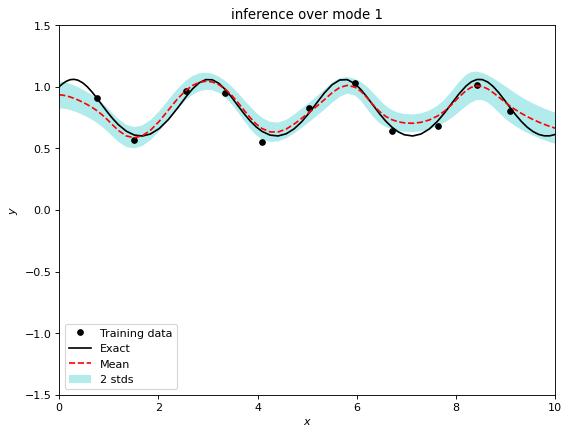

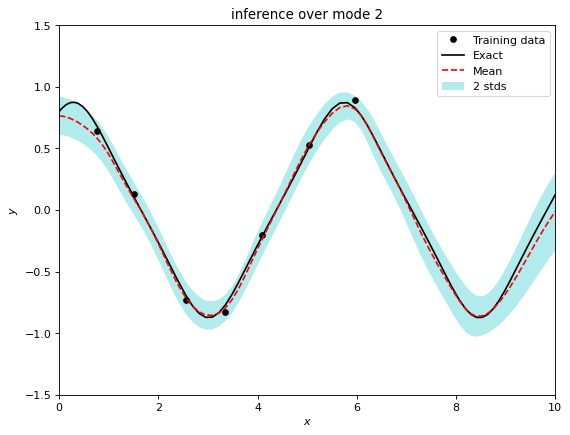

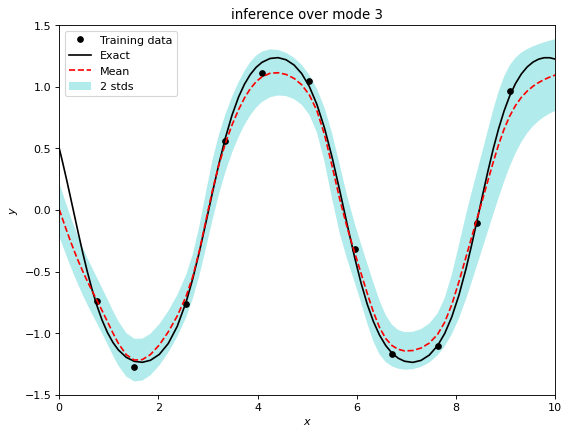

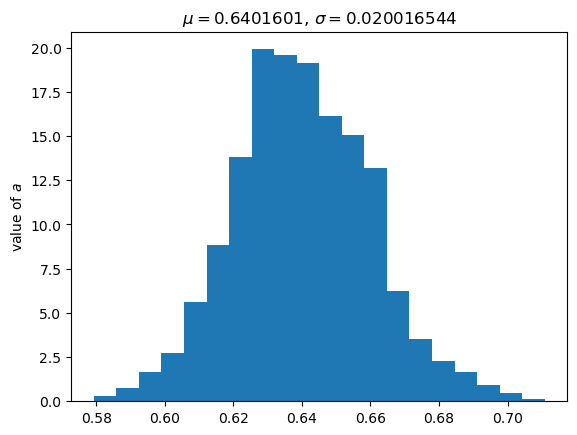

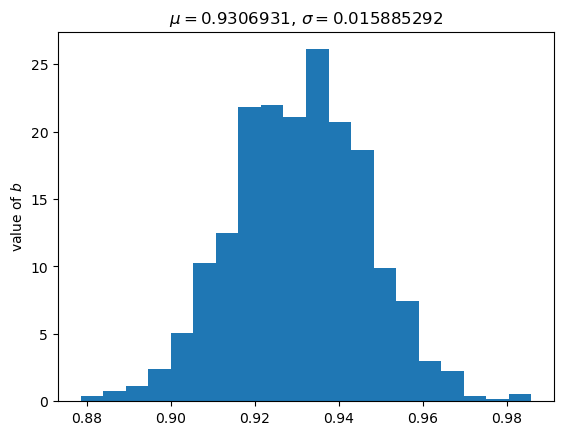

In [112]:
def load_data():
    data = sio.loadmat("./Physics _Informed_NN/GaLA/KO_train.mat")
    t_test, u_test = data["t_test"], data["u_test"]
    t_u_train, u_train = data["t_u_train"], data["u_train"]
    t_f_train, f_train = data["t_f_train"], data["f_train"]
    noise = 0.05
    return t_u_train, u_train, t_f_train, f_train, noise, t_test, u_test


def ode_fn(t, u, a, b):
    u1, u2, u3 = tf.split(u, 3, axis=-1)
    u1_t = tf.gradients(u1, t)[0]
    u2_t = tf.gradients(u2, t)[0]
    u3_t = tf.gradients(u3, t)[0]

    f1 = u1_t - a * u2 * u3
    f2 = u2_t - b * u1 * u3
    f3 = u3_t + (a + b) * u1 * u2
    return tf.concat([f1, f2, f3], axis=-1)


@neuq.utils.timer
def MCD(t_u_train, u_train, t_f_train, f_train, noise, layers):
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]
    t2_train, u2_train = t_u_train[:], u_train[:, 1:2]
    # build processes
    process_u = neuq.process.Process(
        surrogate=neuq.surrogates.FNN(layers=layers, activation=tf.tanh),
        prior=neuq_vars.fnn.Variational(layers=layers, mean=0, sigma=1.0),
        posterior=neuq_vars.fnn.MCD(layers=layers, dropout_rate=0.01, trainable=True),
    )
    process_a = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    process_b = neuq.process.Process(
        surrogate=neuq.surrogates.Identity(),
        prior=neuq_vars.const.Variational(mean=0, sigma=2.0),
        posterior=neuq_vars.const.Variational(mean=0, sigma=1.0, trainable=True),
    )
    # build likelihoods
    likelihood_u13 = neuq.likelihoods.Normal(
        inputs=t_u_train,
        targets=np.concatenate([u1_train, u3_train], axis=-1),
        processes=[process_u],
        out_dims=[[0, 2]],
        sigma=noise,
    )
    likelihood_u2 = neuq.likelihoods.Normal(
        inputs=t2_train,
        targets=u2_train,
        processes=[process_u],
        out_dims=[[1]],
        sigma=noise,
    )
    likelihood_f = neuq.likelihoods.Normal(
        inputs=t_f_train,
        targets=f_train,
        processes=[process_u, process_a, process_b],
        pde=ode_fn,
        sigma=noise,
    )
    # build model
    model = neuq.models.Model(
        processes=[process_u, process_a, process_b],
        likelihoods=[likelihood_u13, likelihood_u2, likelihood_f],
    )
    # assign and compile method
    method = neuq.inferences.VI(
        batch_size=64,
        num_samples=1000,
        num_iterations=20000,
        optimizer=tf.train.AdamOptimizer(1e-3),
    )
    model.compile(method)
    # obtain posterior samples
    samples = model.run()

    processes = [process_u, process_a, process_b]
    return processes, samples, model


def plots(u_pred, t_test, u_test, t_u_train, u_train):
    u1_pred, u2_pred, u3_pred = np.split(u_pred, 3, axis=-1)
    u1_test, u2_test, u3_test = np.split(u_test, 3, axis=-1)
    u1_train, u3_train = u_train[:, 0:1], u_train[:, 2:3]  # training data
    t2_train, u2_train = t_u_train[:7], u_train[:7, 1:2]  # training data

    neuq.utils.plot1d(
        t_u_train,
        u1_train,
        t_test,
        u1_test,
        u1_pred[..., 0],
        title="inference over mode 1",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t2_train,
        u2_train,
        t_test,
        u2_test,
        u2_pred[..., 0],
        title="inference over mode 2",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )
    neuq.utils.plot1d(
        t_u_train,
        u3_train,
        t_test,
        u3_test,
        u3_pred[..., 0],
        title="inference over mode 3",
        xlim=[0, 10],
        ylim=[-1.5, 1.5],
    )


################## Load data and specify some hyperparameters ####################
data = load_data()
t_u_train, u_train, t_f_train, f_train, noise = data[:5]
t_test, u_test = data[5:]
layers = [1, 50, 50, 3]

####################### Build model and perform inference ########################
# All models share the same general procedure:
# Step 1: build surrogate, e.g. a fully-connected neural network, using [surrogates]
# Step 2: build prior and/or posterior using [variables]
# Step 3: build process, based the surrogate, prior and/or posterior, using [Process]
# Step 4: build likelihood, given noisy measurements, using [likelihoods]
# Step 5: build model using [models]
# Step 6: create an inference method and assign it to the model using [inferences]
# Step 7: perform posterior sampling using [model.run]

############################### Choose framework #################################
# processes, samples, model = Samplable(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )
# processes, samples, model = Trainable(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )

# Note: Variational tends to work better, visually, if noise for the likelihood is set
# to be small, based on our experience. However, if the noise is known, we can't justify setting it to a small value,
# just to produce better-looking results.
# processes, samples, model = Variational(
#     t_u_train, u_train, t_f_train, f_train, noise, layers
# )
processes, samples, model = MCD(
    t_u_train, u_train, t_f_train, f_train, noise, layers
)

################################# Predictions ####################################
u_pred, a_pred, b_pred = model.predict(t_test, samples, processes, pde_fn=None)

############################### Postprocessing ###################################
plots(u_pred, t_test, u_test, t_u_train, u_train)
neuq.utils.hist(a_pred.flatten(), name="value of $a$")
neuq.utils.hist(b_pred.flatten(), name="value of $b$")